# House Price Prediction

This is a simple demo showing most of the typical functionality in a MLP implemented in PyTorch. Used data is from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction).

## Data Description

Most of the fields are self-explanatory, only the ones that require more information are described in the following sections.

## Building Grades

* **1-3** Falls short of minimum building standards. Normally cabin or inferior structure.
* **4** Generally older, low quality construction. Does not meet code.
* **5** Low construction costs and workmanship. Small, simple design.
* **6** Lowest grade currently meeting building code. Low quality materials and simple designs.
* **7** Average grade of construction and design. Commonly seen in plats and older sub-divisions.
* **8** Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
* **9** Better architectural design with extra interior and exterior design and quality.
* **10** Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
* **11** Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
* **12** Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
* **13** Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Parameter, ReLU, BatchNorm1d, LeakyReLU, Sigmoid
from torch.optim.lr_scheduler import StepLR
import numpy as np
import opendatasets as od
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt

In [2]:
class HouseDataset(Dataset):
    def __init__(self, datadir="data/housesalesprediction", columns=None):
        """
        Parameters
        ----------
        datadir : str
            Directory where the data is stored / downloaded.
        columns : list
            Names of columns that are kept, everything else is dropped. If None, all the columns are kept
        """
        
        self.datadir = datadir
        self.filename = "kc_house_data.csv"
        self.path_to_file = os.path.join(self.datadir, self.filename)

        # Download if the datafile does not exist
        if not os.path.isfile(self.path_to_file):
            od.download("https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/download?datasetVersionNumber=1")
            os.rename("housesalesprediction", self.datadir)

        # Read in the csv file
        self.features = pd.read_csv(self.path_to_file)

        # Drop id and date from the data
        self.features = self.features.drop(columns=["id", "date"])
        self.price = self.features.price.copy()
        self.features = self.features.drop(columns=["price"])

        # Filter the data
        if columns is not None:
            self.features = self.features[columns]
        
        # Store the column names
        self.column_names = []
        for col in self.features.columns:
            self.column_names.append(col)

        # Convert features and prices to numpy arrays
        features_numpy = self.features.to_numpy(dtype=np.float32)
        prices_numpy = self.features.to_numpy(dtype=np.float32).reshape(-1, 1)

        # Feature scaler
        self.feature_scaler = StandardScaler()
        self.feature_scaler.fit(features_numpy)

        # Price scaler
        self.price_scaler = StandardScaler()
        self.price_scaler.fit(prices_numpy)

        #print(sum(prices_numpy - self.price_scaler.inverse_transform(self.price_scaler.transform(prices_numpy))))
        
        # Convert to tensors for faster access
        self.data_tensor = torch.from_numpy(self.feature_scaler.transform(features_numpy))
        self.price_tensor = torch.from_numpy(self.price_scaler.transform(prices_numpy))

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        return self.data_tensor[idx, :], self.price_tensor[idx]

    def get_column_names(self):
        """
        Returns column names of the data

        Returns
        -------
        list
            List containing the column names
        """
        return self.column_names

    def transform_features(self, x):
        """
        Transform features to have a mean of 0.0 and std of 1.0. Scaler
        parameters are based on the original dataset.
        
        Parameters
        ----------
        x : np.array
            Array to be transformed

        Returns
        -------
        np.array
            Transformed features
        """
        return self.feature_scaler.transform(x)

    def inverse_transform_features(self, x):
        """
        Inverse transforms features back to the original space
        
        Parameters
        ----------
        x : np.array
            Array to be transformed

        Returns
        -------
        np.array
            Inverse transformed features
        """
        return self.feature_scaler.inverse_transform(x)

    def transform_prices(self, x):
        """
        Transform prices to have a mean of 0.0 and std of 1.0. Scaler
        parameters are based on the original dataset.
        
        Parameters
        ----------
        x : np.array
            Array to be transformed

        Returns
        -------
        np.array
            Transformed prices
        """
        return self.price_scaler.transform(x)

    def inverse_transform_prices(self, x):
        """
        Inverse transforms prices back to the original space
        
        Parameters
        ----------
        x : np.array
            Array to be transformed

        Returns
        -------
        np.array
            Inverse transformed prices
        """
        return self.price_scaler.inverse_transform(x)

In [3]:
# Features/columns we want to use from the data
chosen_features = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'condition',
    'grade',
    'sqft_above',
    'sqft_basement',
    'zipcode']

# Create a dataset and split it into training- and test sets
dataset = HouseDataset(columns = chosen_features)
print(dataset.get_column_names())
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode']


In [4]:
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=1.0)
        if module.bias is not None:
            torch.nn.init.normal_(module.bias, mean=0.0, std=10.0)

class SimpleModel(torch.nn.Module):
    def __init__(self, nr_inputs):
        super(SimpleModel, self).__init__()

        self.model = torch.nn.Sequential(
            Linear(nr_inputs, 40, bias = False),
            BatchNorm1d(40),
            LeakyReLU(),
            Linear(40, 50),
            BatchNorm1d(50),
            LeakyReLU(),
            Linear(50, 100),
            BatchNorm1d(100),
            LeakyReLU(),
            Linear(100, 1)
        )
        
        self.model.apply(init_weights)
                
    def forward(self, x):
        return self.model(x)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel(nr_inputs = len(dataset.get_column_names()))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Size of the training data set: 17291
Size of the validation data set: 2161

--- Starting training ---
Epoch: 0/1000, training loss: 9.189699660329257, validation loss: 3.370828067555147
Epoch: 10/1000, training loss: 1.4835573675877907, validation loss: 1.1898184313493616
Epoch: 20/1000, training loss: 1.2415622514398659, validation loss: 1.0900007240912493
Epoch: 30/1000, training loss: 1.161705315551337, validation loss: 1.0016813313259798
Epoch: 40/1000, training loss: 1.1150503640665728, validation loss: 0.9675476673771354
Epoch: 50/1000, training loss: 1.092432726831997, validation loss: 0.9676392166053548
Epoch: 60/1000, training loss: 1.0772470542613197, validation loss: 0.9609587332781624
Epoch: 70/1000, training loss: 1.0689496156923912, validation loss: 0.9701267410727108
Epoch: 80/1000, training loss: 1.0588460807852886, validation loss: 0.9502896245788125
Epoch: 90/1000, training loss: 1.0559522849233711, validation loss: 0.9478295655811534
Epoch: 100/1000, training loss: 1

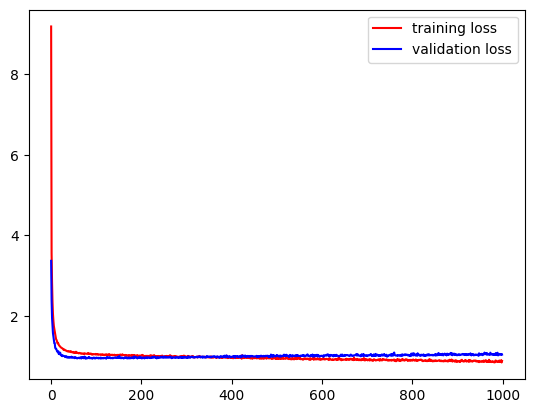

In [6]:
print(f"Size of the training data set: {len(train_set)}")
print(f"Size of the validation data set: {len(validation_set)}")

num_epochs = 1000

loss_function = torch.nn.MSELoss()

training_losses = []
validation_losses = []

print("")
print("--- Starting training ---")

for epoch in range(num_epochs):

    training_loss = []
    validation_loss = []
    
    model.train()
    for step, (features, price) in enumerate(train_loader):
        features = features.to(device)
        price = price.to(device)
    
        # Forward pass
        output = model(features)
        loss = loss_function(output, price)
        training_loss.append(loss.item())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        for step, (features, price) in enumerate(validation_loader):
            features = features.to(device)
            price = price.to(device)

            # Forward pass
            output = model(features)
            loss = loss_function(output, price)
            validation_loss.append(loss.item())
    
    
    training_losses.append(np.mean(training_loss))
    validation_losses.append(np.mean(validation_loss))
    
    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}, training loss: {training_losses[-1]}, validation loss: {validation_losses[-1]}")
    
plt.plot(training_losses, 'r-', label="training loss")
plt.plot(validation_losses, 'b-', label="validation loss")
plt.legend()
plt.show()

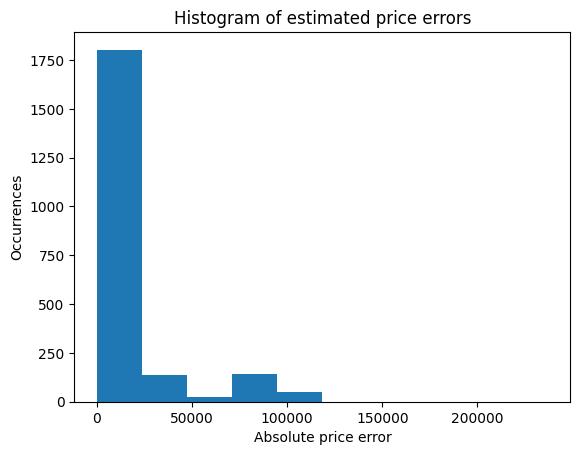

In [17]:
# Show histogram of absolute error between the ground truth and the estimated prices
model.eval()
with torch.no_grad():

    # Store the absolute errors, for each batch, to a list
    absolute_errors = []
    for features, prices in test_loader:
        features = features.to(device)
        estimated_prices = model(features)
    
        estimated_prices = dataset.inverse_transform_prices(estimated_prices.to("cpu"))
        prices = dataset.inverse_transform_prices(prices)
        absolute_errors.append(np.absolute(prices-estimated_prices))

    # Concatenate the list into an array
    absolute_errors = np.concatenate(absolute_errors)
    counts, bins = np.histogram(absolute_errors, bins=10)
    
    plt.title("Histogram of estimated price errors")
    plt.hist(bins[:-1], bins, weights=counts)
    plt.xlabel("Absolute price error")
    plt.ylabel("Occurrences")
    plt.show()